In [71]:
import clip
import re
import torch
from tqdm import tqdm
from clip import tokenize
import cv2
import numpy as np
from torchvision.transforms import Resize
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import CLIPTokenizerFast

os.sys.path.append(os.path.dirname(os.path.abspath('..')))
from util.visualization import attr_to_subplot

from urllib.request import urlopen

from util.attribution_methods.CLIP.generate_emap import imgprocess_keepsize, mm_interpret, \
        clip_encode_dense, grad_eclip, grad_cam, mask_clip, compute_rollout_attention, \
        clip_surgery_map, m2ib_clip_map, generate_masks, rise, clip_lrp

import util.attribution_methods.CLIP.Game_MM_CLIP.clip as mm_clip
from util.attribution_methods.CLIP.CLIP_Surgery import clip as surgery_clip
from util.attribution_methods.CLIP.CLIP_lrp.CLIP.clip import clip as lrp_clip
from util.attribution_methods.CLIP.M2IB.scripts.clip_wrapper import ClipWrapper
from util.attribution_methods import MDAFunctions
from util.test_methods import MASTestFunctions as MAS

device = "cuda" if torch.cuda.is_available() else "cpu"

# clipmodel, preprocess = clip.load("ViT-B/16", device=device)
# mm_clipmodel, _ = mm_clip.load("ViT-B/16", device=device, jit=False)
# surgery_model, _ = surgery_clip.load("CS-ViT-B/16", device=device)
# m2ib_model = ClipWrapper(clipmodel)
# clip_tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch16")

clipmodel, preprocess = clip.load("ViT-B/32", device=device)
mm_clipmodel, _ = mm_clip.load("ViT-B/32", device=device, jit=False)
surgery_model, _ = surgery_clip.load("CS-ViT-B/32", device=device)
m2ib_model = ClipWrapper(clipmodel)
clip_tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

def heatmap_overlap(img, attr, name, alpha = 0.6, cmap = 'jet'):
    attr = attr.detach().cpu().numpy()
    fig, axs = plt.subplots(1, 1)
    attr_to_subplot(attr, name, axs, cmap = cmap, norm = 'absolute', blended_image = img, alpha = alpha)

    return

# heatmap
def heatmap_overlap_axs(img, attr, name, axs, alpha = 1):
    attr = attr.detach().cpu().numpy()
    attr_to_subplot(attr, name, axs, cmap = 'jet', norm = 'absolute', blended_image = img, alpha = alpha)
    return

In [72]:
with open('../../util/class_maps/ImageNet/ILSVRC2012_validation_ground_truth.txt') as f:
    gnd_truth = [int(line.strip()) for line in f.readlines()]
with open('../../util/class_maps/ImageNet/map_clsloc.txt') as f:
    class_map = [line.strip() for line in f.readlines()] 
with open('../../util/class_maps/ImageNet/imagenet_classes.txt') as f:
    class_list = [line.strip() for line in f.readlines()]
    
clip_labels = [f"a photo of a {label}" for label in class_list]
all_text_processed = clip.tokenize(clip_labels).cuda()
all_classes_embedding = [clipmodel.encode_text(text.unsqueeze(0)).detach().cpu() for text in all_text_processed]
all_classes_embedding = F.normalize(torch.from_numpy(np.array(all_classes_embedding)), dim=-1).to(device)

Ground truth: a photo of a macaque id: 373


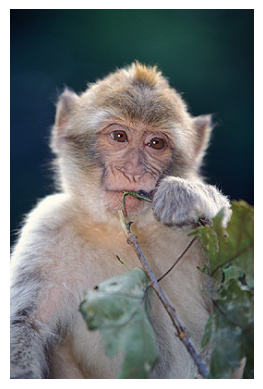

In [85]:
img_path = "../../../ImageNet/ILSVRC2012_val_00000095.JPEG"
img_num = int(img_path.split(".")[-2].split("_")[-1]) - 1

map_line = gnd_truth[img_num]
class_info = class_map[map_line - 1]
class_name = (class_info.split(" ")[-1]).replace('_', ' ')
true_class_index = class_list.index(class_name)
caption = "a photo of a " + class_name

img = Image.open(img_path).convert("RGB")
print("Ground truth:", caption, "id:", true_class_index)

plt.imshow(img)
plt.axis('off')
plt.show()

In [86]:
img_hw = 224
# transforms for IG, LIG, and IDG
transform = transforms.Compose([
     transforms.Resize((img_hw)),
     transforms.CenterCrop(img_hw),
])

print_transform = transforms.Compose([
     transforms.Resize((img_hw)),
     transforms.CenterCrop(img_hw),
     transforms.ToTensor()
])

resize = transforms.Resize((img_hw))
trans_img = transform(img)
print_img = print_transform(img)

img = transforms.functional.to_pil_image(print_img)

text_processed = clip.tokenize([caption]).cuda()
# extract text featrue
text_embedding = clipmodel.encode_text(text_processed)
text_embedding = F.normalize(text_embedding, dim=-1)
print("[text embedding]:", text_embedding.shape)

[text embedding]: torch.Size([1, 512])


In [87]:
# query the model to see its prediction of the image given the dataset labels
img_embedding = clipmodel.encode_image(preprocess(img).to(device).unsqueeze(0))

# similarities = F.normalize(img_embedding, dim=-1) @ F.normalize(all_classes_embedding.squeeze(), dim=-1).T
similarities = img_embedding @ all_classes_embedding.squeeze().T

# similarities against ground truth
print("GT Similarities")
print(similarities[:, true_class_index].item())
print(torch.nn.functional.softmax(similarities, dim=-1)[:, true_class_index].item())
print(torch.nn.functional.softmax(similarities / .1, dim=-1)[:, true_class_index].item())

# similarities against predicition
pred = similarities.argmax()

print("\nPrediction:", clip_labels[pred], "id:", pred)

if pred != true_class_index:
    print("Incorrect!")
else:
    print("Correct!")

GT Similarities
3.59765625
0.004283905029296875
0.5625

Prediction: a photo of a macaque id: tensor(373, device='cuda:0')
Correct!


In [88]:
import time

def get_CLIP_pred(input_tensor, model, all_classes_embedding):
    img_embedding = model.encode_image(input_tensor)
    similarities = img_embedding @ all_classes_embedding.squeeze().T
    pred_class = similarities.argmax().item()
    prediction = torch.nn.functional.softmax(similarities / 0.1, dim=-1)[:, pred_class].item()

    return pred_class, prediction

# https://github.com/Cyang-Zhao/Grad-Eclip

def generate_hm(hm_type, img, txt_embedding, txts, resize):
    start = time.time()
    img_keepsized = imgprocess_keepsize(img).to(device).unsqueeze(0)
    outputs, v_final, last_input, v, q_out, k_out,\
        attn, att_output, map_size = clip_encode_dense(img_keepsized, clipmodel)
    img_embedding = F.normalize(outputs[:,0], dim=-1)
    cosines = (img_embedding @ txt_embedding.T)[0]

    if hm_type == "selfattn":
        emap = attn[0,:1,1:].detach().reshape(*map_size)
    elif "gradcam" in hm_type:
        emap = [grad_cam(c, last_input, map_size) for c in cosines]
        emap = torch.stack(emap, dim=0).sum(0)
    elif "maskclip" in hm_type:
        emap = mask_clip(txt_embedding.T, v_final, k_out, map_size)
        emap = emap.sum(0)
    elif "grad_eclip" in hm_type:
        emap = [grad_eclip(c, q_out, k_out, v, att_output, map_size, withksim=False) \
            if "wo-ksim" in hm_type else grad_eclip(c, q_out, k_out, v, att_output, map_size, withksim=True) \
            for c in cosines]
        emap = torch.stack(emap, dim=0).sum(0)  
    elif "eclip" in hm_type:
        emap = [grad_eclip(c, q_out, k_out, v, att_output, map_size, withksim=False, withgrad=False) \
            if "wo-ksim" in hm_type else grad_eclip(c, q_out, k_out, v, att_output, map_size, withksim=True, withgrad=False) \
            for c in cosines]
        emap = torch.stack(emap, dim=0).sum(0)  
    elif "game" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        text_tokenized = mm_clip.tokenize(txts).to(device)
        emap = mm_interpret(model=mm_clipmodel, image=img_clipreprocess, texts=text_tokenized, device=device)    
        emap = emap.sum(0) 
    elif "rollout" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        text_tokenized = mm_clip.tokenize(txts).to(device)
        attentions = mm_interpret(model=mm_clipmodel, image=img_clipreprocess, texts=text_tokenized, device=device, rollout=True)      
        emap = compute_rollout_attention(attentions)[0]
    elif "surgery" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        all_texts = ['airplane', 'bag', 'bed', 'bedclothes', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling', 'chair', 'cloth', 'computer', 'cow', 'cup', 'curtain', 'dog', 'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground', 'horse', 'keyboard', 'light', 'motorbike', 'mountain', 'mouse', 'person', 'plate', 'platform', 'potted plant', 'road', 'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow', 'sofa', 'table', 'track', 'train', 'tree', 'truck', 'tv monitor', 'wall', 'water', 'window', 'wood']
        all_texts = txts + all_texts
        emap = clip_surgery_map(model=surgery_model, image=img_clipreprocess, texts=all_texts, device=device)[0,:,:,0]
    elif "m2ib" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        emap = m2ib_clip_map(model=m2ib_model, clip_tokenizer=clip_tokenizer, image=img_clipreprocess, texts=txts, device=device)
        emap = torch.tensor(emap)
    elif "rise" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).unsqueeze(0)
        emap = rise(model=clipmodel, image=img_clipreprocess, txt_embedding=txt_embedding, device=device)
    elif "lrp" in hm_type:
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        # _, hm = clip_lrp(img_clipreprocess, lrp_clip.tokenize(txts[0]).to(device), lrp_clipmodel, "cuda:0")
        _, hm = clip_lrp(img_clipreprocess, lrp_clip.tokenize(txts[0]).to(device), mm_clipmodel, "cuda:0")
        emap = hm.reshape((-1, int(np.sqrt(hm.shape[-1])), int(np.sqrt(hm.shape[-1]))))
    
    emap = resize(emap.unsqueeze(0))[0].squeeze().reshape((224, 224, -1))

    return emap

def visualize(hmap, raw_image, resize):
    image = np.asarray(raw_image.copy())
    hmap = resize(hmap.unsqueeze(0))[0].cpu().numpy()
    color = cv2.applyColorMap((hmap*255).astype(np.uint8), cv2.COLORMAP_JET) # cv2 to plt
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


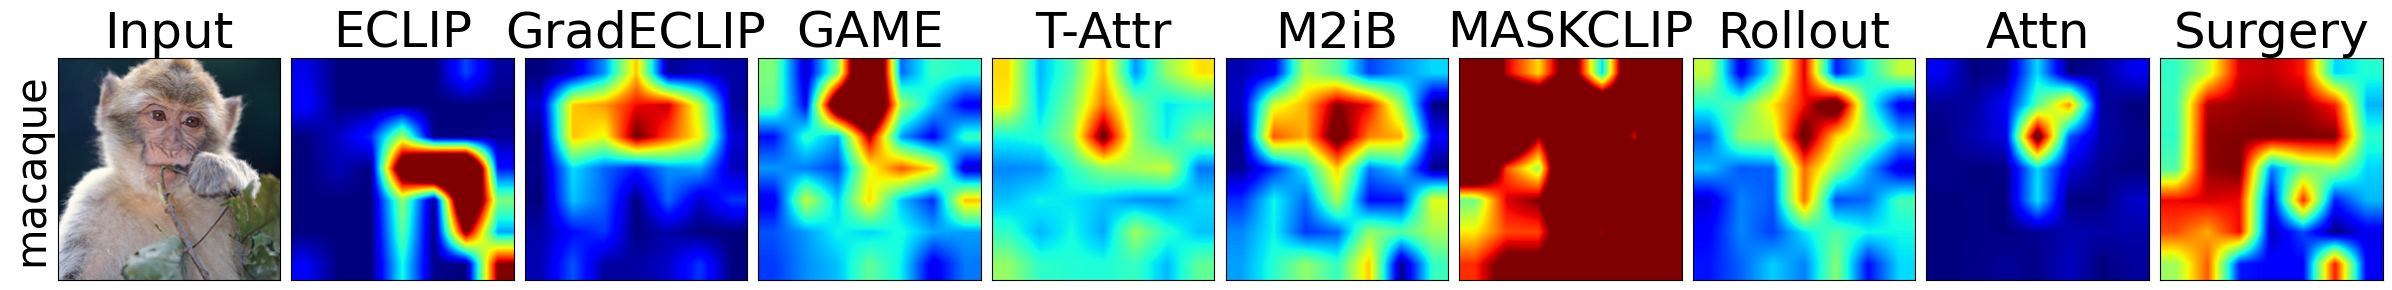

In [89]:
hm_type = 'eclip'
eclip_attr = generate_hm(hm_type, img, text_embedding, [caption], resize)

hm_type = 'grad_eclip'
grad_eclip_attr = generate_hm(hm_type, img, text_embedding, [caption], resize)

hm_type = 'lrp'
clip_lrp_attr = generate_hm(hm_type, img, text_embedding, [caption], resize)

hm_type = 'game'
game_attr = generate_hm(hm_type, img, text_embedding, [caption], resize)

hm_type = 'maskclip'
maskclip_attr = generate_hm(hm_type, img, text_embedding, [caption], resize)

hm_type = 'rollout'
rollout_att = generate_hm(hm_type, img, text_embedding, [caption], resize)

hm_type = 'selfattn'
selfattn_att = generate_hm(hm_type, img, text_embedding, [caption], resize)

hm_type = 'surgery'
surgery_att = generate_hm(hm_type, img, text_embedding, [caption], resize)

hm_type = 'm2ib'
m2ib_att = generate_hm(hm_type, img, text_embedding, caption, resize)

plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 10, figsize = (30, 3))
attr_to_subplot(print_img, "Input", axs[0], original_image = True)
heatmap_overlap_axs(print_img, eclip_attr, 'ECLIP', axs[1])
heatmap_overlap_axs(print_img, grad_eclip_attr, 'GradECLIP', axs[2])
heatmap_overlap_axs(print_img, game_attr, 'GAME', axs[3])
heatmap_overlap_axs(print_img, clip_lrp_attr, 'T-Attr', axs[4])
heatmap_overlap_axs(print_img, m2ib_att, 'M2iB', axs[5])
heatmap_overlap_axs(print_img, maskclip_attr, 'MASKCLIP', axs[6])
heatmap_overlap_axs(print_img, rollout_att, 'Rollout', axs[7])
heatmap_overlap_axs(print_img, selfattn_att, 'Attn', axs[8])
heatmap_overlap_axs(print_img, surgery_att, 'Surgery', axs[9])
axs[0].set_ylabel(class_name)
plt.subplots_adjust(wspace = 0.05)
plt.show()
fig.savefig('my_plot.png', dpi=100, bbox_inches='tight')